In [1]:
sys.path.append("..")
import utils
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def read_all_results(dir_path = "../results/"):
    paths = os.listdir(dir_path)
    rel_paths = []
    for i in range(len(paths)):
        if not (paths[i] == '.DS_Store' or paths[i] == 'archive'):
            rel_paths.append("results/" + paths[i])
            
            print(paths[i].split("_")[2] + " " + paths[i].split("_")[3])
    return rel_paths

## Plot vaccinated distribution for all results

infection based
fhi policy
susceptible based
infection based
oldest first
contact based
Reading results ..
100%|██████████| 500/500 [00:10<00:00, 48.30it/s]


<Figure size 432x288 with 0 Axes>

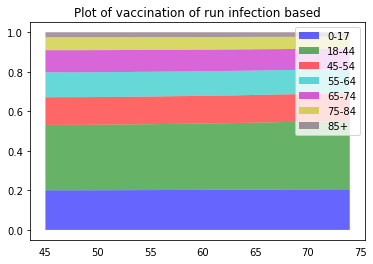

Reading results ..


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [3]:
paths = read_all_results()
for relative_path in paths:
    age_labels, vaccines_available, flow_scale,contact_weights,S_regions,I_regions,new_infected_regions,new_deaths_regions,vaccinated_regions,S_age_groups,         I_age_groups,new_infected_age_groups,new_deaths_age_groups,vaccinated_age_groups = utils.read_csv(relative_path=relative_path)
    vaccinated_mean = vaccinated_age_groups.mean(axis=0)
    norm = np.where(np.int64(vaccinated_mean.sum(axis=1, keepdims=True))==0, 1, vaccinated_mean.sum(axis=1, keepdims=True))
    vaccinated = np.divide(vaccinated_mean, norm)
    vaccinated_cumsum = vaccinated.cumsum(axis=1)
    week_cut = np.where(vaccinated_mean > 0)[0][0]

    plt.figure()
    fig, ax = plt.subplots(1)
    weeks = np.arange(vaccinated_mean.shape[0])
    ax.fill_between(weeks[week_cut:], 0, vaccinated_cumsum[week_cut:,0], label = age_labels[0], facecolor="b", alpha=.6)
    ax.fill_between(weeks[week_cut:], vaccinated_cumsum[week_cut:,0], vaccinated_cumsum[week_cut:,1], label = age_labels[1], facecolor="g", alpha=.6)
    ax.fill_between(weeks[week_cut:], vaccinated_cumsum[week_cut:,1], vaccinated_cumsum[week_cut:,2], label = age_labels[2], facecolor="r", alpha=.6)
    ax.fill_between(weeks[week_cut:], vaccinated_cumsum[week_cut:,2], vaccinated_cumsum[week_cut:,3], label = age_labels[3], facecolor="c", alpha=.6)
    ax.fill_between(weeks[week_cut:], vaccinated_cumsum[week_cut:,3], vaccinated_cumsum[week_cut:,4], label = age_labels[4], facecolor="m", alpha=.6)
    ax.fill_between(weeks[week_cut:], vaccinated_cumsum[week_cut:,4], vaccinated_cumsum[week_cut:,5], label = age_labels[5], facecolor="y", alpha=.6)
    ax.fill_between(weeks[week_cut:], vaccinated_cumsum[week_cut:,5], vaccinated_cumsum[week_cut:,6], label = age_labels[6], facecolor="#6E5160", alpha=.6)
    plt.title(f"Plot of vaccination of run {relative_path.split('_')[2]} {relative_path.split('_')[3]}")
    plt.legend()
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True)
    plt.show()

infection based
fhi policy
susceptible based
infection based
oldest first
contact based
Reading results ..
100%|██████████| 500/500 [00:08<00:00, 56.88it/s]


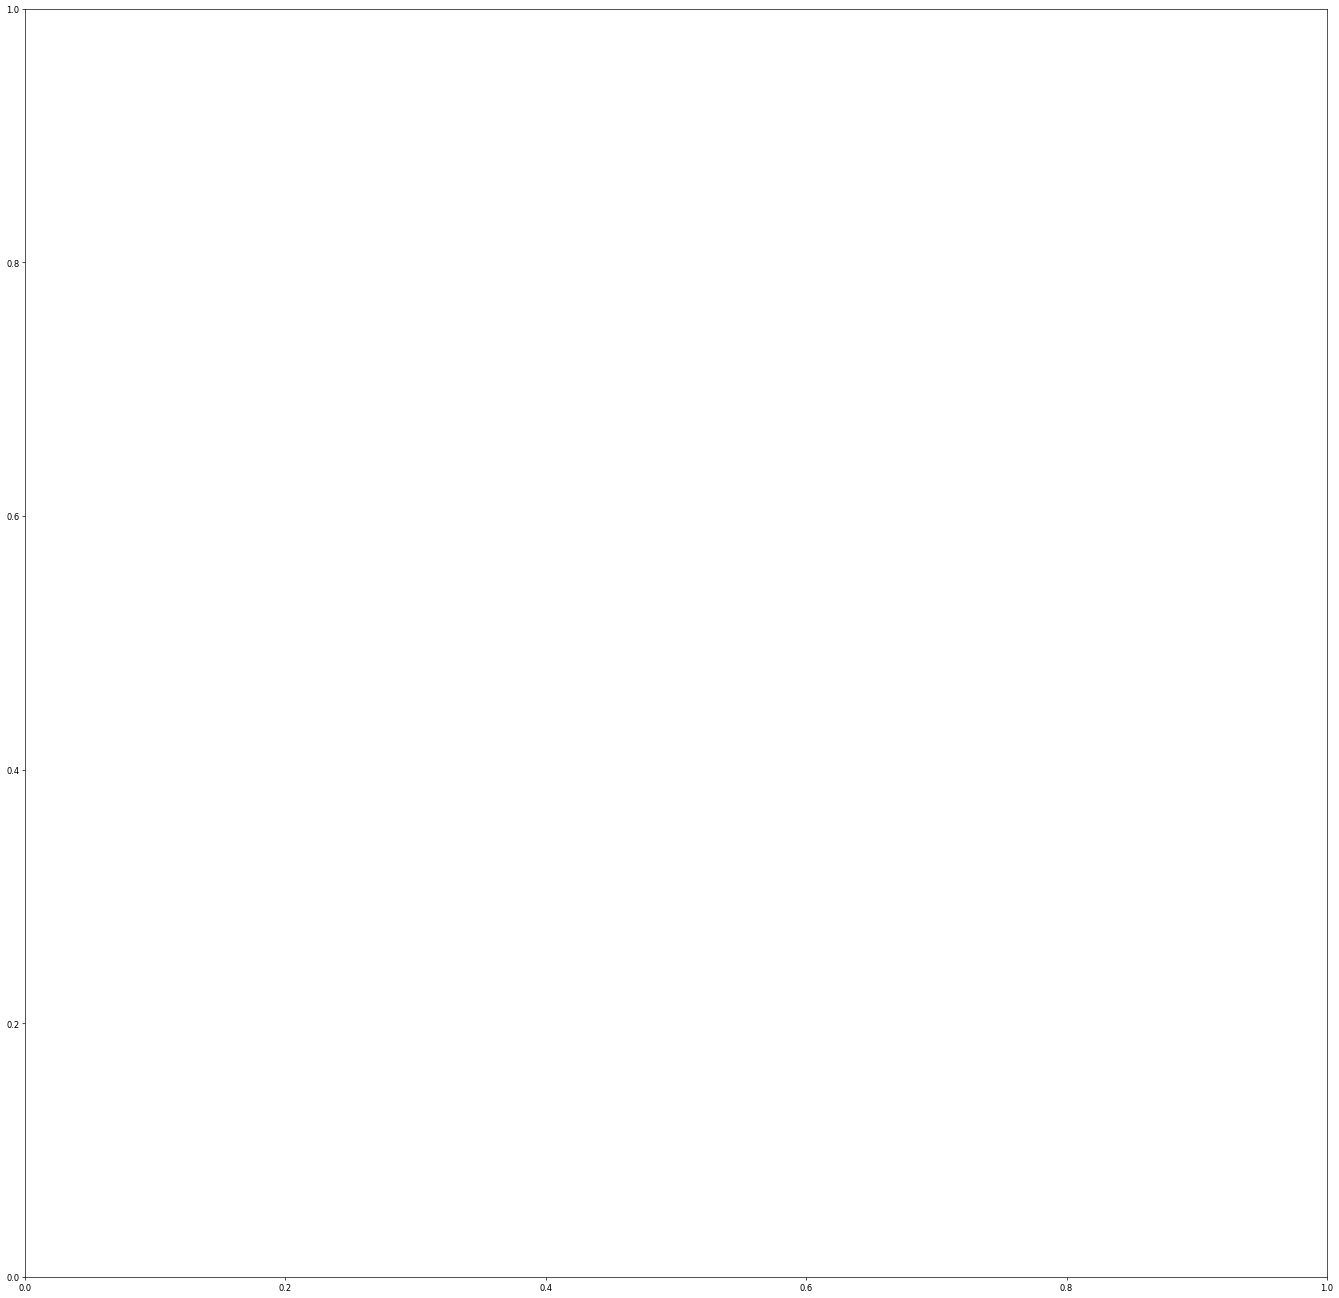

In [7]:
paths = read_all_results()
for relative_path in paths[:1]:
   age_labels, vaccines_available, flow_scale,contact_weights,S_regions,I_regions,new_infected_regions,new_deaths_regions,vaccinated_regions,S_age_groups, I_age_groups,new_infected_age_groups,   new_deaths_age_groups,vaccinated_age_groups = utils.read_csv(relative_path=relative_path)

fig, ax = plt.subplots(figsize=(28,28), dpi=60)
paths = utils.create_named_tuple('paths', 'filepaths.txt')
config = utils.create_named_tuple('config', paths.config)


## Geographic plot of vaccines (in progress)

In [8]:
population = utils.generate_custom_population(config.age_bins, age_labels)
gdf = utils.generate_geopandas(population, paths.municipalities_geo)
gdf.plot(column='population', ax=ax, facecolor='white', edgecolor='black', alpha=0.5, linewidth=0.5, zorder=2,  legend=True, vmin=100, vmax=800000, )
plt.show()

<Figure size 432x288 with 0 Axes>

## Analysis of simulations needed

In [4]:
results = {}
for relative_path in paths:
    results[relative_path] = utils.read_csv(relative_path=relative_path)

Reading results ..
100%|██████████| 500/500 [00:10<00:00, 47.69it/s]
Reading results ..
100%|██████████| 500/500 [00:10<00:00, 47.50it/s]
Reading results ..
100%|██████████| 500/500 [00:10<00:00, 46.18it/s]
Reading results ..
100%|██████████| 500/500 [00:12<00:00, 39.70it/s]
Reading results ..
100%|██████████| 500/500 [00:11<00:00, 43.65it/s]
Reading results ..
100%|██████████| 500/500 [00:15<00:00, 32.29it/s]


In [5]:
objective_values = {}
for keys in results.keys():
    objective_values[keys] = np.zeros(3) #element 0: deaths, element 1: infected, element 2: yll
    

In [18]:
key = list(results.keys())[0]
print("finding results for ", key)
result = results[key]
age_labels = result[0]
paths = utils.create_named_tuple('paths', 'filepaths.txt')
config = utils.create_named_tuple('config', paths.config)

new_deaths_age_groups = result[-2]
cumulative_deaths = new_deaths_age_groups.cumsum(axis=1)
cum_deaths = np.zeros((cumulative_deaths.shape[0], cumulative_deaths.shape[2]))
yll = np.zeros((cumulative_deaths.shape[0]))
for i in range(cumulative_deaths.shape[0]):
    cum_deaths[i] = cumulative_deaths[i,-1,:]
    yll[i] = utils.calculate_yll(utils.get_expected_yll(config.age_bins, age_labels),  cum_deaths[i]) 
print(yll.shape)
deaths = np.sum(cum_deaths, axis=1)
print(deaths.shape)

new_infected_age_groups = result[-3]
cumulative_infected = new_infected_age_groups.cumsum(axis=1)
cum_infected = np.zeros((cumulative_infected.shape[0]))
for i in range(cumulative_infected.shape[0]):
    cum_infected[i] = np.sum(cumulative_infected[i,-1,:])
print(cum_infected.shape)

finding results for  results/500_simulations_infection_based_2021_05_31_19_53_10
(500,)
(500,)
(500,)


In [ ]:


deaths_mean = final_deaths.mean(axis=0)
cumulative_deaths_mean = cumulative_deaths.mean(axis=0)
u_percentile_deaths = np.percentile(final_deaths, percentile_limit, axis=0)
l_percentile_deaths = np.percentile(final_deaths, 100-percentile_limit, axis=0)
u_percentile_deaths_cum = np.percentile(deaths_cumulative, percentile_limit, axis=0)
l_percentile_deaths_cum = np.percentile(deaths_cumulative, 100-percentile_limit, axis=0)

cumulative_infected = final_infected.cumsum(axis=1)
infected_mean = final_infected.mean(axis=0)
cumulative_infected_mean = cumulative_infected.mean(axis=0)
u_percentile_infected = np.percentile(final_infected, percentile_limit, axis=0)
l_percentile_infected = np.percentile(final_infected, 100-percentile_limit, axis=0)
u_percentile_infected_cum = np.percentile(infected_cumulative, percentile_limit, axis=0)
l_percentile_infected_cum = np.percentile(infected_cumulative, 100-percentile_limit, axis=0)